In [2]:
using LinearAlgebra
using Plots
using LaTeXStrings


In [3]:

"""
function gauss_quad(p)

Gaussian quadrature on [-1,1] for given degree of precision `p`
"""
function gauss_quad(p)
    n = ceil((p+1)/2)
    b = 1:n-1
    b = @. b / sqrt(4*b^2 - 1)
    eval, evec = eigen(diagm(1 => b, -1 => b))
    return eval, 2*evec[1,:].^2
end

"""
    legendre_poly(x, p)

Legendre polynomials and derivatives up to degree `p` at nodes `x`
"""
function legendre_poly(x, p)
    z = zeros(size(x))
    o = ones(size(x))
    y = hcat(o, x, repeat(z, 1, p-1))
    dy = hcat(z, o, repeat(z, 1, p-1))
    for i = 1:p-1
        @. y[:,i+2] = ((2i+1)*x*y[:,i+1] - i*y[:,i]) / (i+1)
        @. dy[:,i+2] = ((2i+1)*(x*dy[:,i+1] + y[:,i+1]) - i*dy[:,i]) / (i+1)
    end
    y, dy
end

"""
    c = cheb(p)

Gives chebyshev nodes at p+1 points, on [-1, 1]
"""
cheb(p) = @. -cos(pi * (0:p) / p)

"""
    C = coeffs(p)

Coefficient matrix of basis, up to degree p
inverts vandermonde matrix of Legendre polynomials at chebyshev nodes
"""
coeffs(p) = inv(legendre_poly(cheb(p), p)[1])

"""
    M, K = get_matrices(p, h)

Returns elemental mass and stiffness matrices M and K
on an element of length h, using Legendre polynomials up to degree p
Gaussian quadrature at 2p points is used to evalute integrals
"""
function get_matrices(p, h)
    C = coeffs(p)
    gx, gw = gauss_quad(2p)
    pL, dpL = legendre_poly(gx, p)

    Mel = zeros(p+1, p+1)
    Kel = zeros(p+1, p+1)
    for i=1:p+1, j=1:p+1
        for k=1:p+1
            φi = dot(C[:, i],  pL[k, :])
           dφi = dot(C[:, i], dpL[k, :])
            φj = dot(C[:, j],  pL[k, :])
            Mel[i, j] += gw[k] *  φi * φj
            Kel[i, j] += gw[k] * dφi * φj
        end
    end
    Mel *= h/2
    return Mel, Kel
end

"""
    r = rhs_convect(u, M, K)
Computes the rhs of the convection equation
"""
function rhs_convect(u, Mel, Kel)
    r = Kel * u
    r[end,:] = r[end,:] - u[end,:]
    r[1,:] = r[1,:] + u[end, [end; 1:end-1]]
    r = Mel \ r
end

"""
U = solveODE(f, u0, H, h)
Solves u'(x) = f(u(x)) for x in [0, H], with Δx = h,
using RK4-scheme, for some initial condition u0.
Saves solution at all points in matrix U.
"""
function solveODE(; f, u0, H, h)
    function rk4_step(u)
        k1 = h * f(u)
        k2 = h * f(u + k1/2)
        k3 = h * f(u + k2/2)
        k4 = h * f(u + k3)
        u + (k1 + 2k2 + 2k3 + k4) / 6
    end

    steps = round(Int, H/h) + 1
    U = zeros(steps, size(u0)...)
    U[1, :, :] = u0
    for t = 1:steps-1
        U[t+1, :, :] = rk4_step(U[t, :, :])
    end
    return U
end

"""
φ = basis(x, p)

Interpolates the basis functions of degree p at points x
"""
function basis(x, p)
    C = coeffs(p)
    pL, _ = legendre_poly(x, p)
    φ = zeros(p+1, length(x))
    for i=1:p+1, k=1:length(x)
        φ[i, k] += dot(C[:, i], pL[k, :])
    end
    return φ
end

"""
    y = get_sol(u, φ)

returns value of solution using matrix u;
containing solutin coefficients for basis at all degrees and all elements,
    and basis φ evaluated at interpolated points.
"""
function get_sol(u, φ)
    n = size(u, 2)  # number of elements
    m = size(φ, 2)  # number of interpolated points
    y = zeros(m, n)
    for e = 1:n
        y[:, e] = sum(u[:, e] .* φ, dims=1)
    end
    return y
end


get_sol

In [42]:

"""
    animate(U, dt, exact, frame_skip)

Animates solution U, together with exact solution.
Is also be used to plot final solution
"""
function animate(U, dt; exact=nothing, frame_skip=5, name="")
    if length(size(U)) == 2
        U = reshape(U, 1, size(U)...)
    end
    nT, p, n = size(U)
    p -= 1
    h = 1 / n

    s = @. (0:10p-1) / (10p-1)  # 3p equidistant points on [0, 1]
    c = @. 2s - 1  # 3p equidistant points on [-1, 1]
    x = @. h * s + (0:h:1-h)'

    φ = basis(c, p)  # basis functions evaluated at equidistant points

    xx = (0:0.01:1)
    @gif for t = 1 : size(U, 1)
        u = get_sol(U[t, :, :], φ)
        plot(x, u, lw=5, color="blue", label=nothing)
        if exact !== nothing
            plot!(xx, exact.(xx, t*dt), lw=3, color="black", label="Analytic")
        end
        plot!(title=name*". t = $(round((t == 1 ? t : t - 1)*dt, digits=4))")
        plot!(xlabel="x", ylabel="y", ylim=[0, 1])
    end every frame_skip
    if size(U, 1) == 1
        savefig("figs/u_final"*name*".pdf")
    end
end


animate

In [5]:

"""
    error = calc_err(n, u, h, f)

Calculates error as continuous L2-norm of difference between numerical and true solution on domain
Uses gaussian quadrature to integrate difference
First finds gauss_quad points in [-1, 1], shifts them to [0, 1],
finds what element each gq-point is in, and for each transforms it
into relative point on [-1, 1] in each element.
"""
function calc_err(n_pts, sol, h, exact_f)
    x, w = gauss_quad(n_pts)  # on [-1, 1]
    shifted = @. (x + 1) / 2  # on [0, 1]
    element = @. Int(floor(shifted / h))
    in_elem = @. shifted / h - element
    eleshift = @. 2 * in_elem - 1  # back to [-1, 1], but relative to own element

    φelem = basis(eleshift, size(sol, 1)-1)

    numerical = sum(sol[:, element .+ 1] .* φelem, dims=1)
    exact = exact_f.(shifted)

    diff = numerical' .- exact
    error = sqrt(h * dot(w, diff .^ 2) / 2)
end


calc_err

In [23]:

uinit(x) = exp(-(x - 0.5)^2 / 0.1^2)
uinit(x, t) = uinit(mod(x- t, 1.))

""""
Solves the convection problem using discontinuous galerkin method
with n elements, and basis functions of degree up to p. The basis functions
are linear combinations of the Legendre polynomials evaluated at chebyshev nodes in each element
Returns only the solution at t=T, as well as error, where the exact solution is known
"""
function dgconvect(; n=10, p=1, T=1., dt=1e-3, anim=false)
    # Discretization
    h = 1 / n
    c = cheb(p)  # chebyshev points on [-1, 1]
    x = @. h * ((c + 1) / 2) + (0:h:1-h)'  # chebyshev points in all elements

    M, K = get_matrices(p, h)
    rhs(y) = rhs_convect(y, M, K)
    U = solveODE(f=rhs, u0=uinit.(x), H=T, h=dt)
    u_final = U[end, :, :]
    if anim
        animate(U, dt; exact=uinit, frame_skip=10)
    end

    error = calc_err(5p, u_final, h, uinit)
    return u_final, error
end

"""
Performs a convergence test of dgconvect
Makes a matrix of errors for different values of n and p,
and makes a loglog plot of errors with slopes
returns errors and slopes
"""
function dgconvect_convergence()
    errors = zeros(5, 5)  # init error storage, and loop over params to fill
    nps = []
    for nppow = 4:8  # powers of p and n specified in ps7
        for ppow = 0:4
            p = 2^ppow
            n = Int(2^nppow / p)
            u, e = dgconvect(p=p, n=n, dt=2e-4);
            errors[ppow+1, nppow-3] = e
        end
        push!(nps, 2^nppow)
    end

    log_errs = log10.(errors)
    log_nps = log10.(nps)
    display(log_errs)

    x = (log_nps[1]:0.1:log_nps[end])  # domain to plot against
    P = plot(title="Convergence convection", xlabel=L"log_{10}(n \cdot p)", ylabel=L"log_{10}(error)", legend=:bottomleft)
    # incl = [[:], [:], [:], [1,2,3,4], [3]]  # set points to include in linear fit
    incl = [5, 5, 5, 4, 3]  # set how many points to include in linear fit
    slopes = []
    for p = 1:5
        X = zeros(incl[p], 2)  # vandermonde matrix
        X[:, 1] .= log_nps[(1:incl[p])]
        X[:, 2] .= 1
        slope, inter = X \ log_errs[p, :][(1:incl[p])]
        plot!(log_nps, log_errs[p, :], color=p, st=:scatter, marskersize=10, label=nothing, ylim=(-12., -1.5))
        plot!(x, x .* slope .+ inter, color=p, markersize=0, lw=3, label="p = $(2^p), slope = $(round(slope, digits=4))")
        push!(slopes, slope)
    end
    display(P)
    # savefig("figs/conv_conv.pdf")
    return errors, slopes
end


dgconvect_convergence

In [33]:

# u, e = dgconvect(p=2, n=6, dt=1e-3, anim=true)
# animate(u, 1, exact=uinit, name="convect")
# dgconvect_convergence()


┌ Info: Saved animation to 
│   fn = /home/hakon/Documents/UiO/Sem8/Berkeley2022/NumSolDiffEq/PS7/tmp.gif
└ @ Plots /home/hakon/.julia/packages/Plots/YAlrZ/src/animation.jl:114


([-0.0023245765929719594 0.0016703061471452865 … 0.1165883452153034 -0.0020298260956131105; -0.0027814499716790207 -0.013921755155799197 … -0.04341195545569568 0.0154554109137722; -0.012982674979351844 0.14977798190563188 … -0.012491139907932339 -0.0003445565344022982], 0.039937522132064994)

In [31]:


"""
    r = rhs_convdiff(u, M, K)
Computes the rhs of the convection-diffusion equation
"""
function rhs_convdiff(u, k, M, K)
    t = -K * u
    t[1,:] = t[1,:] - u[1,:]
    t[end,:] = t[end,:] + u[1, [2:end; 1]]
    σ = M \ t

    r = K * (u - k * σ)
    r[end,:] = r[end,:] - u[end,:] + k * σ[end,:]
    r[1,:] = r[1,:] + u[end, [end; 1:end-1]] - k * σ[end, [end; 1:end-1]]
    r = M \ r
end

uexact(x, t, k, i) = 1/sqrt(1 + 400 * k * t) * exp(-100 * (x - 0.5 - t + i)^2 / (1 + 400 * k * t))
uexact(x, t, k) = sum([uexact(x, t, k, i) for i = -2:2])

"""
Does exactly the same as dgconvect,
but solves convection-diffusion problem.
Code is copied, and minimally modified
"""
function dgconvdiff(; n=10, p=1, T=1., dt=1e-3, k=1e-3, anim=false)
    # Discretization
    h = 1 / n
    c = cheb(p)  # chebyshev points on [-1, 1]
    x = @. h * ((c + 1) / 2) + (0:h:1-h)'  # chebyshev points in all elements

    M, K = get_matrices(p, h)
    rhs(y) = rhs_convdiff(y, k, M, K)
    U = solveODE(f=rhs, u0=uinit.(x), H=T, h=dt)
    u_final = U[end, :, :]
    if anim
        animate(U, dt; exact=((x,t)->uexact(x, t, k)), frame_skip=10)
    end

    error = calc_err(2p, u_final, h, (x->uexact(x, T, k)))
    return u_final, error
end

"""
Does exactly the same as dgconvect_convergence,
but solves convection-diffusion problem.
Code is copied, and minimally modified
"""
function dgconvdiff_convergence(k=1e-3)
    errors = zeros(5, 5)
    nps = []
    for nppow = 4:8
        for ppow = 0:4
            p = 2^ppow
            dt = (nppow + ppow == 12) ? 1e-5 : 2e-4
            n = Int(2^nppow / p)
            u, e = dgconvdiff(p=p, n=n, dt=dt, k=k);
            errors[ppow+1, nppow-3] = e
        end
        push!(nps, 2^nppow)
    end

    log_errs = log10.(errors)
    log_nps = log10.(nps)
    display(log_errs)
    
    x = (log_nps[1]:0.1:log_nps[end])
    P = plot(title="Convergence convection-diffusion", xlabel=L"log_{10}(n \cdot p)", ylabel=L"log_{10}(error)", legend=:bottomleft)
    incl = [5, 5, 5, 4, 3]
    slopes = []
    for p = 1:5
        X = zeros(incl[p], 2)
        X[:, 1] .= log_nps[(1:incl[p])]
        X[:, 2] .= 1
        slope, inter = X \ log_errs[p, :][(1:incl[p])]
        plot!(log_nps, log_errs[p, :], color=p, st=:scatter, marskersize=10, label=nothing, ylim=(-13.5, -1.5))
        plot!(x, x .* slope .+ inter, color=p, markersize=0, lw=3, label="p = $(2^p), slope = $(round(slope, digits=4))")
        push!(slopes, slope)
    end
    display(P)
    savefig("figs/conv_diff.pdf")
    return errors, slopes
end


dgconvdiff_convergence

5×5 Matrix{Float64}:
 -2.63559  -3.65904   -5.04285   -5.81175   -7.26302
 -2.12322  -3.85416   -4.62827   -5.98371   -7.73116
 -2.18548  -3.38889   -5.21538   -7.24767   -9.52504
 -2.31628  -5.05725   -7.57414  -10.2005   -12.1555
 -2.18706  -6.17456  -10.9182   -11.806    -12.776

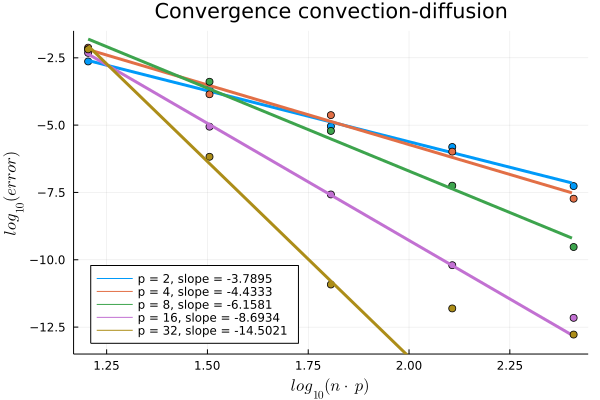

([0.002314231755936962 0.00021925863136807214 … 1.542593157472432e-6 5.457336274430063e-8; 0.007529741054310458 0.00013990767080306562 … 1.0382273345485558e-6 1.857107269049462e-8; … ; 0.004827446242553986 8.764991342575547e-6 … 6.301913990163619e-11 6.990897491414777e-13; 0.0065003507306360805 6.690201774172751e-7 … 1.5632936168148204e-12 1.674907834930554e-13], Any[-3.7895085969298115, -4.4332576030398245, -6.158148851475252, -8.693360891745082, -14.5020534443198])

In [32]:
dgconvdiff_convergence()

In [50]:

k = 1e-3
u, e = dgconvdiff(p=3, n=4, dt=1e-3, k=1e-2, anim=true)
# animate(u, 1, exact=((x,t)->uexact(x,t,k)), name="convdiff")
# dgconvdiff_convergence(k)

┌ Info: Saved animation to 
│   fn = /home/hakon/Documents/UiO/Sem8/Berkeley2022/NumSolDiffEq/PS7/tmp.gif
└ @ Plots /home/hakon/.julia/packages/Plots/YAlrZ/src/animation.jl:114


([0.006854711686929531 0.1363909193594945 0.45989597376578123 0.13637790657258397; 0.010306608241043581 0.2347990360535419 0.4267268481325209 0.06763838868099685; 0.06838703472210228 0.425644541686406 0.2348498719149619 0.010574329927400108; 0.13666560966642785 0.45977287490911295 0.13645959912358255 0.006618279487723636], 0.0057350602052113914)